In [ ]:
# Install and import the necessary libraries
!pip install -q -U torch
!pip install -q -U accelerate peft bitsandbytes transformers trl einops evaluate
!pip install -q -U tqdm
!pip install -q -U git+https://github.com/sissa-data-science/DADApy
!pip install scikit-dimension

In [5]:
import os
import torch
from datasets import load_dataset
from datasets import load_from_disk
from peft import LoraConfig, prepare_model_for_kbit_training, PeftModel
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    pipeline,
    logging,
    DistilBertModel,
    DistilBertTokenizer,
)
from tqdm import tqdm
from trl import SFTTrainer
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
# from dadapy.data import Data
import numpy as np
import skdim

In [6]:
# Model
base_model = "microsoft/phi-2"

# Dataset
dataset = load_dataset("prsdm/MedQuad-phi2-1k", split="train")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=True)
tokenizer.pad_token=tokenizer.eos_token
tokenizer.padding_side="right"

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
# Function that tokenizes the text
def tokenize(rows):
    # Retrieve Text
    if rows["text"][0] is None:
        text = ""
    else:
        text = rows["text"][0].replace('"', r'\"')

    # Tokenize
    encoded = tokenizer(
          text,
          add_special_tokens=True,
          max_length=260,
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors='pt',
        ).to("cuda")
    return encoded

In [8]:
# Applying tokenization to the dataset
tokenized_dataset = dataset.map(tokenize,
                                batched=True,
                                batch_size=1,
                                remove_columns=["text"])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [9]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    device_map={"": 0},
)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
import torch
import gc
from tqdm import tqdm
import skdim

# Constants
torch.cuda.empty_cache()
gc.collect()
num_data = 200
per_batch = 25
number_batches = num_data // per_batch

# Collect hidden layers
hidden_layers = []

# Collect hidden layers per batch
for batch in tqdm(range(number_batches)):
    for i in range(per_batch):
        # Extract inputs from the dataset using the tokenizer
        inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

        # Perform forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Append the hidden states to the list
        liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
        hidden_layers.append(liste)
        del outputs, liste, inputs
        torch.cuda.empty_cache()
        gc.collect()

# Move back to CPU
torch.set_default_device("cpu")

# Process hidden layers
hidden_layers_avg = []
n = len(hidden_layers[0])
for j in range(n):
    avg_batch_layer = []
    for i in range(number_batches * per_batch):
        layer = hidden_layers[i][j].detach().cpu()
        avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
    hidden_layers_avg.append(avg_batch_layer)

# Handle empty tensors
for layer in hidden_layers_avg:
    for idx, tensor in enumerate(layer):
        if tensor.shape == torch.Size([]):
            print("Encountered empty tensor. Filling with zeros.")
            layer[idx] = torch.zeros(2560)

# Stack hidden layers
hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
hidden_layers_stacked = torch.stack(hidden_layers_stacked)

del hidden_layers, hidden_layers_avg
gc.collect()

# Compute intrinsic dimensions
intrinsic_dims = []
for i in range(n):
    X = hidden_layers_stacked[i].numpy()

    # Example using TwoNN ID Estimator
#     nn_estimator = skdim.id.TwoNN()
#     id_estimate = nn_estimator.fit_transform(X)
#     intrinsic_dims.append(id_estimate)

    # 2NN ID Estimator
#     data = Data(X)
#     data.remove_identical_points()
#     id_list_2NN,_, _ = data.return_id_scaling_2NN() 
#     intrinsic_dims.append(id_list_2NN[1])

    # KNN ID Estimator
#     knn_estimator = skdim.id.KNN()
#     id_estimate = knn_estimator.fit_transform(X)
#     intrinsic_dims.append(id_estimate)

    # MLE ID Estimator
#     mle_estimator = skdim.id.MLE()
#     id_estimate = mle_estimator.fit_transform(X)
#     intrinsic_dims.append(id_estimate)

    # ESS ID Estimator
    ess_estimator = skdim.id.ESS()
    id_estimate = ess_estimator.fit_transform(X)
    intrinsic_dims.append(id_estimate)

    # FisherS ID Estimator
#     fisherS_estimator = skdim.id.FisherS()
#     id_estimate = fisherS_estimator.fit_transform(X)
#     intrinsic_dims.append(id_estimate)

    # Correlation Dimension ID Estimator
#     corrInt_estimator = skdim.id.CorrInt()
#     id_estimate = corrInt_estimator.fit_transform(X)
#     intrinsic_dims.append(id_estimate)

    # TLE ID Estimator
#     tle_estimator = skdim.id.TLE()
#     id_estimate = tle_estimator.fit_transform(X)
#     intrinsic_dims.append(id_estimate)

100%|██████████| 8/8 [02:38<00:00, 19.85s/it]


In [ ]:
intrinsic_dims

In [ ]:
for i in range(len(intrinsic_dims)):
    intrinsic_dims[i] = round(intrinsic_dims[i], 2)
print(intrinsic_dims)

In [2]:
# id_2nn_scale = [27.99,
# 22.52,
# 23.82,
# 22.31,
# 26.18,
# 27.3,
# 24.95]
id_knn = [6, 2560, 2560, 3, 3, 31, 2560, 190, 3, 2, 2560, 3, 2560, 2, 2, 2, 3, 29, 8, 3, 73, 2560, 4, 2560, 2, 2560, 2560, 2560, 2, 18, 2560, 10, 7]
id_mle = [12.77, 12.37, 11.95, 11.37, 11.12, 10.96, 10.58, 10.28, 10.17, 10.3, 10.22, 10.16, 10.15, 10.08, 9.9, 9.81, 9.91, 9.71, 9.71, 9.69, 9.74, 9.71, 9.68, 9.66, 9.73, 9.7, 9.56, 9.67, 9.92, 10.16, 9.9, 9.76, 10.07]
id_2NN = [14.94, 15.68, 16.18, 16.07, 15.52, 15.04, 13.61, 12.86, 12.21, 12.0, 12.07, 12.54, 13.01, 13.27, 13.54, 13.49, 13.74, 13.93, 14.1, 13.86, 12.79, 12.4, 11.72, 10.94, 10.27, 9.29, 9.23, 9.24, 9.3, 10.31, 10.58, 10.93, 9.33] 
# id_ess = [15.38,
# 29.66,
# 25.13,
# 26.72,
# 38.41,
# 44.01,
# 43.83]
id_fs = [4.66, 4.58, 3.76, 3.53, 3.5, 3.64, 3.66, 3.66, 3.66, 3.6, 3.62, 3.64, 3.73, 3.71, 3.68, 3.67, 3.66, 3.65, 3.58, 3.58, 3.56, 3.54, 3.54, 3.58, 3.62, 3.67, 3.68, 3.67, 3.68, 4.21, 4.07, 4.11, 3.65]
id_corrInt = [5.77, 5.39, 5.04, 4.88, 4.35, 4.13, 4.17, 4.27, 4.08, 3.86, 3.65, 3.78, 3.64, 3.57, 3.46, 3.37, 3.25, 3.31, 3.26, 3.34, 3.49, 3.64, 3.71, 4.36, 4.47, 4.05, 3.79, 3.55, 3.38, 3.2, 3.39, 3.29, 3.43] 
id_tle = [10.86, 10.4, 10.1, 9.66, 9.45, 9.32, 9.05, 8.8, 8.71, 8.81, 8.74, 8.76, 8.75, 8.69, 8.53, 8.47, 8.55, 8.4, 8.36, 8.31, 8.34, 8.27, 8.28, 8.26, 8.29, 8.2, 8.08, 8.11, 8.28, 8.49, 8.36, 8.35, 8.61]

In [12]:
import matplotlib.pyplot as plt
import numpy as np

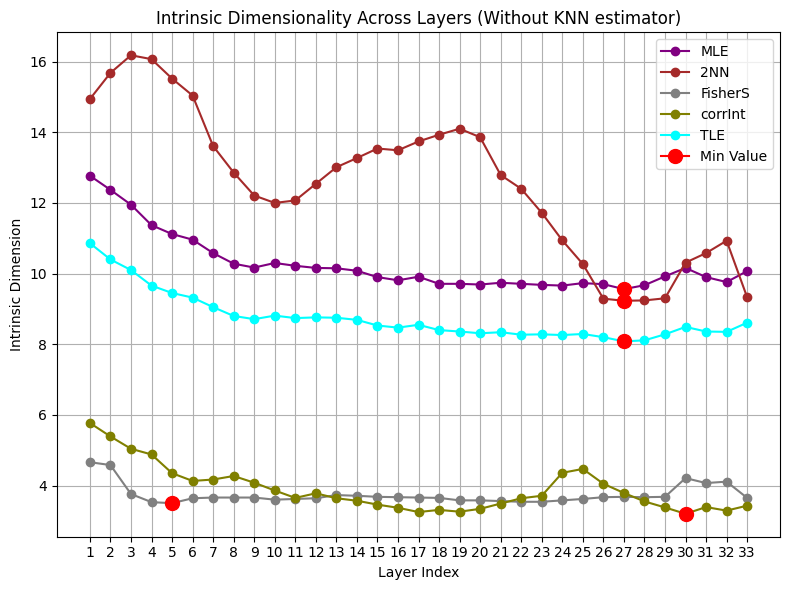

In [17]:
# Plot results
# Find the index of the minimum value
# min_index_2 = id_2nn_scale.index(min(id_2nn_scale)) + 1
min_index_3 = id_knn.index(min(id_knn)) + 1
min_index_4 = id_mle.index(min(id_mle)) + 1
min_index_5 = id_2NN.index(min(id_2NN)) + 1
# min_index_6 = mean_id_ess.index(min(id_ess)) + 1
min_index_7 = id_fs.index(min(id_fs)) + 1
min_index_8 = id_corrInt.index(min(id_corrInt)) + 1
min_index_9 = id_tle.index(min(id_tle)) + 1


# Plot results
plt.figure(figsize=(8, 6))

# plt.plot(np.arange(1, 34), id_2nn_scale, marker='o', linestyle='-', label='2NN scale', color='orange')
# plt.plot(min_index_2, min(id_2nn_scale), marker='o', color='red', markersize=10)

# plt.plot(np.arange(1, 34), id_knn, marker='o', linestyle='-', label='KNN',color='green')
# plt.plot(min_index_3, min(id_knn), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 34), id_mle, marker='o', linestyle='-', label='MLE',color='purple')
plt.plot(min_index_4, min(id_mle), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 34), id_2NN, marker='o', linestyle='-', label='2NN',color='brown')
plt.plot(min_index_5, min(id_2NN), marker='o', color='red', markersize=10)

# plt.plot(np.arange(1, 34), id_ess, marker='o', linestyle='-', label='ESS',color='pink')
# plt.plot(min_index_6, min(id_ess), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 34), id_fs, marker='o', linestyle='-', label='FisherS',color='gray')
plt.plot(min_index_7, min(id_fs), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 34), id_corrInt, marker='o', linestyle='-', label='corrInt',color='olive')
plt.plot(min_index_8, min(id_corrInt), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 34), id_tle, marker='o', linestyle='-', label='TLE',color='cyan')
plt.plot(min_index_9, min(id_tle), marker='o', color='red', markersize=10, label='Min Value')

plt.title('Intrinsic Dimensionality Across Layers (Without KNN estimator)')
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension')
plt.grid(True)
plt.xticks(np.arange(1, 34))
plt.legend()
plt.tight_layout()
plt.savefig("optimizing_layer.png")
plt.show()

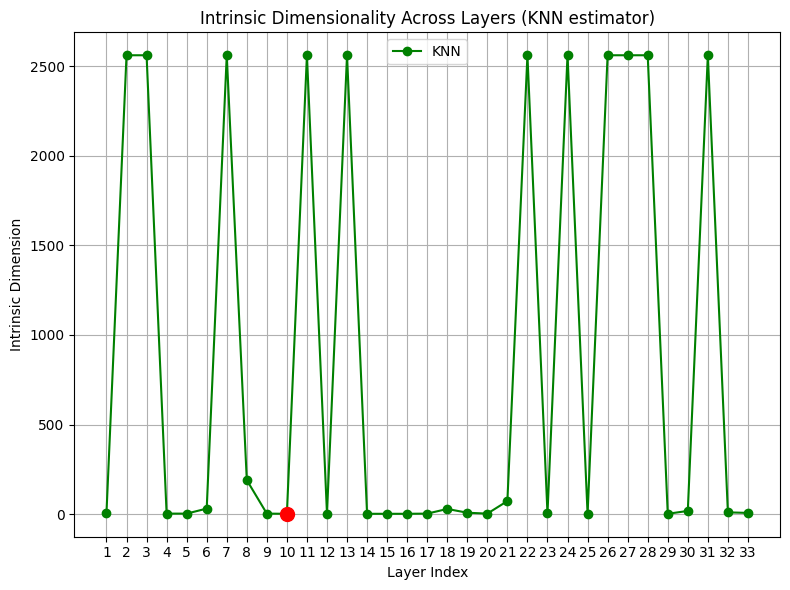

In [19]:
# Plot results
# Find the index of the minimum value
# min_index_2 = id_2nn_scale.index(min(id_2nn_scale)) + 1
min_index_3 = id_knn.index(min(id_knn)) + 1
min_index_4 = id_mle.index(min(id_mle)) + 1
min_index_5 = id_2NN.index(min(id_2NN)) + 1
# min_index_6 = mean_id_ess.index(min(id_ess)) + 1
min_index_7 = id_fs.index(min(id_fs)) + 1
min_index_8 = id_corrInt.index(min(id_corrInt)) + 1
min_index_9 = id_tle.index(min(id_tle)) + 1


# Plot results
plt.figure(figsize=(8, 6))

# plt.plot(np.arange(1, 8), id_2nn_scale, marker='o', linestyle='-', label='2NN scale', color='orange')
# plt.plot(min_index_2, min(id_2nn_scale), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 34), id_knn, marker='o', linestyle='-', label='KNN',color='green')
plt.plot(min_index_3, min(id_knn), marker='o', color='red', markersize=10)

# plt.plot(np.arange(1, 34), id_mle, marker='o', linestyle='-', label='MLE',color='purple')
# plt.plot(min_index_4, min(id_mle), marker='o', color='red', markersize=10)

# plt.plot(np.arange(1, 34), id_2NN, marker='o', linestyle='-', label='2NN',color='brown')
# plt.plot(min_index_5, min(id_2NN), marker='o', color='red', markersize=10)

# plt.plot(np.arange(1, 8), id_ess, marker='o', linestyle='-', label='ESS',color='pink')
# plt.plot(min_index_6, min(id_ess), marker='o', color='red', markersize=10)

# plt.plot(np.arange(1, 34), id_fs, marker='o', linestyle='-', label='FisherS',color='gray')
# plt.plot(min_index_7, min(id_fs), marker='o', color='red', markersize=10)

# plt.plot(np.arange(1, 34), id_corrInt, marker='o', linestyle='-', label='corrInt',color='olive')
# plt.plot(min_index_8, min(id_corrInt), marker='o', color='red', markersize=10)

# plt.plot(np.arange(1, 34), id_tle, marker='o', linestyle='-', label='TLE',color='cyan')
# plt.plot(min_index_9, min(id_tle), marker='o', color='red', markersize=10, label='Min Value')

plt.title('Intrinsic Dimensionality Across Layers (KNN estimator)')
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension')
plt.grid(True)
plt.xticks(np.arange(1, 34))
plt.legend()
plt.tight_layout()
plt.savefig("optimizing_layer.png")
plt.show()